# Getting starting with the GRIDmeter™ library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the stratified sampling model, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.


    

# Background -- why this library

The `gridmeter` library originated from a project lead by Recurve Analytics, Inc. and funded by the US Dept. of Energy designed to identify practical methods for analyzing energy efficiency which are robust to external shocks (e.g. COVID-19).  From June through September 2020, Recurve hosted a series of meetings with industry stakeholders to discuss methods for constructing comparison groups, with the goal of presenting a recommended standard method to the GRID working group, a subsidiary of the Linux Foundation for Energy.  During this time, Recurve developed Python software to implement stratified sampling and demonstrate its effectiveness in practice.  The `gridmeter` library is the open-source Apache-licensed output of this process and is available to be used by anyone. 

This notebook will take you through several things that this library can do.


## Note on tutorial scope and related libraries

This tutorial assumes the reader has properly installed python and has a basic working knowledge of python syntax and usage. 

The `gridmeter` library uses `pandas` data frames as its principle way of representing data, therefore all inputs and outputs are data frames; see [this tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for information on how to use `pandas`.  The `plotnine` library is used to make visualizations which can be embedded in a Jupyter notebook or saved as .pngs; see [this website](https://plotnine.readthedocs.io/en/stable/) for information on `plotnine`.

In [1]:
import numpy as np
from eemeter import gridmeter as gm

## Viewing documentation

You can view code documentation by appending a question mark to a function and then executing that code, as in the following example:

# Problem definition

Typically one begins with two populations of meters: a **treatment group**, and a **comparison pool**.  The treatment group consists of those meters for which savings needs to be tracked, e.g. if they represent customers participating in an energy efficiency program.  The comparison pool consists of all of the available meters that are not part of the treatment group.  The goal is to select a **comparison group** which is a subset of the comparison pool, such that the control group is **similar** to the treatment group.  The comparison group will then provide a realistic counterfactual compared to the treatment group and can be used to accurately estimate the impact of a program.

# Setting up data

Gridmeter uses the `Data` class as the inputs to all of the comparison group methods. Its purpose is to validate your data and to perform the necessary transformations to go into the comparison group methods. `Data` is instantiated with `Data_Settings`. Once instantiated the method `.set_data` can be called using one of `loadshape_df` and `time_series_df` as well as `features_df` depending upon your needs. If you input `time_series_df` it will compute the loadshape.

Method requirements:
- Clustering: Loadshape
- Individual Meter Matching: Loadshape
- Stratified Sampling: Loadshape/Features (depends upon settings)

In [2]:
# Load and assign data

# data_type = "month_loadshape"
# data_type = "seasonal_day_of_week_loadshape"
data_type = "seasonal_hourly_day_of_week_loadshape"

df_ls_all = gm.load_tutorial_data(data_type)

# randomly select 100 ids from df_ls_all
all_ids = df_ls_all.index.to_list()
t_ids = np.random.choice(all_ids, 100, replace=False)

df_ls_treatment = df_ls_all.loc[t_ids]

# remove t_ids from all_ids
all_ids = [x for x in all_ids if x not in t_ids]
cp_ids = np.random.choice(all_ids, 1000, replace=False)

df_ls_pool = df_ls_all.loc[cp_ids]

In [3]:
# Set data classes

pool_data = gm.Data(loadshape_df=df_ls_pool)
treatment_data = gm.Data(loadshape_df=df_ls_treatment)

# Random Sampling


In [4]:
rs_settings = gm.RS_Settings()
rs = gm.Random_Sampling(rs_settings)
df_cg, df_t_coeffs = rs.get_comparison_group(treatment_data, pool_data)

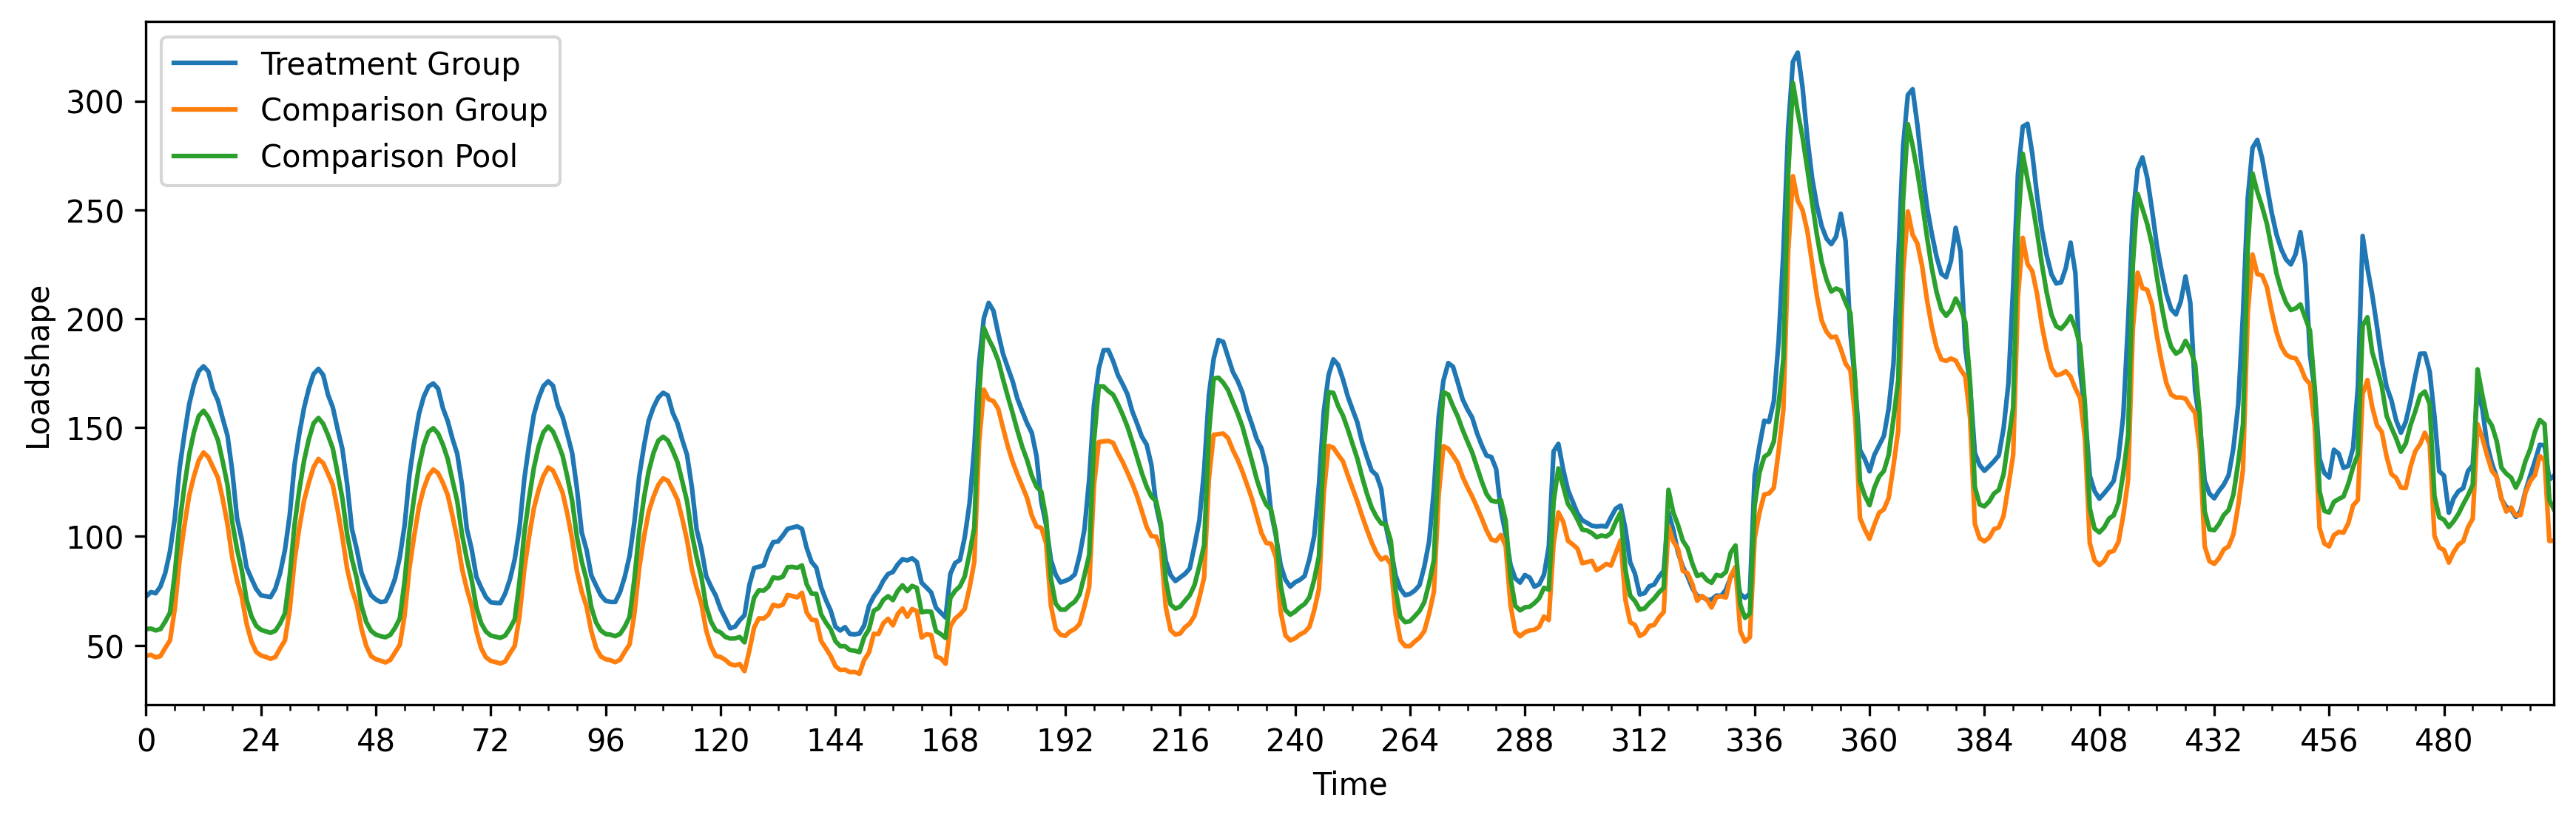

In [5]:
rs.plot_loadshapes()

# Individual Meter Matching
For Euclidean distance matching, the usage patterns of each treatment meter are compared to the usage patterns of each comparison pool meter in order to find the closest matches. The subsequent group of meters that have been "matched" become the resulting comparison group.

## Features For Matching

Any usage pattern can be used for euclidean distance matching. If an 8760 hourly trace is available, it is suggested to use a 'seasonal-hour-of-week' load-shape (3 168-point load shapes, one for summer, winter, and shoulder). If only monthly data is available, it is suggested to use the 12 months of usage as the usage pattern.


In [6]:
imm_settings = gm.IMM_Settings()
imm = gm.IMM(imm_settings)
df_cg, df_t_coeffs = imm.get_comparison_group(treatment_data, pool_data)

In [7]:
df_cg

,treatment,distance,duplicated,cluster,weight
id,,,,,
115863,109985,1559.184634,False,0,1
120533,109227,112.742480,False,0,1
116458,119858,242.716163,False,0,1
120078,112900,32.347202,False,0,1
115180,119214,104.162463,False,0,1
...,...,...,...,...,...
116979,109164,243.065706,False,0,1
120859,113632,98.281442,False,0,1
118482,115995,13804.602756,False,0,1


In [8]:
df_ls_treatment

,1,2,3,4,5,6,7,8,9,10,...,495,496,497,498,499,500,501,502,503,504
id,,,,,,,,,,,,,,,,,,,,,
109985,98.860959,91.762589,89.769439,83.779655,91.393893,108.476428,148.934372,183.058705,213.427612,292.540600,...,296.627306,348.598603,380.744526,324.842272,404.667246,445.183968,363.521135,418.127063,205.420299,97.260598
109227,7.892701,6.849416,6.765176,6.358343,5.916849,7.452363,13.411821,19.957851,26.859637,31.602353,...,17.474491,17.424883,18.797100,21.614173,24.530506,25.780613,27.088073,28.426911,29.470330,30.020242
119858,11.055222,11.313101,10.919605,10.407444,10.269240,11.441261,13.302167,19.098249,26.496942,32.468556,...,39.690045,39.974814,43.052057,47.929276,52.205530,55.422545,59.088670,62.945396,65.723675,66.977886
112900,3.367958,3.391149,3.226486,3.099977,3.048617,2.962656,2.216899,2.046691,3.517835,5.849776,...,13.116536,12.371116,12.596120,12.991021,14.457785,15.765177,16.875724,17.945289,18.619424,18.728837
119214,9.019878,9.656670,9.681387,9.482874,9.228300,8.893945,9.148255,10.834152,11.415523,12.700021,...,15.547963,14.776385,15.272451,16.694519,20.488749,23.122645,24.195751,25.185535,26.366163,27.359788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109164,17.625570,14.626635,14.157766,13.875723,13.718584,13.199472,11.531697,22.617691,34.045530,39.649962,...,62.382291,62.598552,63.297755,64.055615,66.713857,69.006423,72.289415,75.311324,75.468377,76.882847
113632,5.654624,5.276861,5.211595,5.032945,4.688243,4.583364,6.529560,10.123205,13.650582,17.614191,...,9.961923,10.042445,10.172816,10.335871,11.269999,11.163825,11.134810,11.307837,11.585155,12.252720
115995,116.825679,97.355026,80.616692,69.584879,68.291537,63.901616,241.229113,830.000549,898.879572,978.745047,...,632.205600,637.820259,659.035032,720.982368,800.445376,838.126537,867.780583,904.049404,944.548546,966.938264


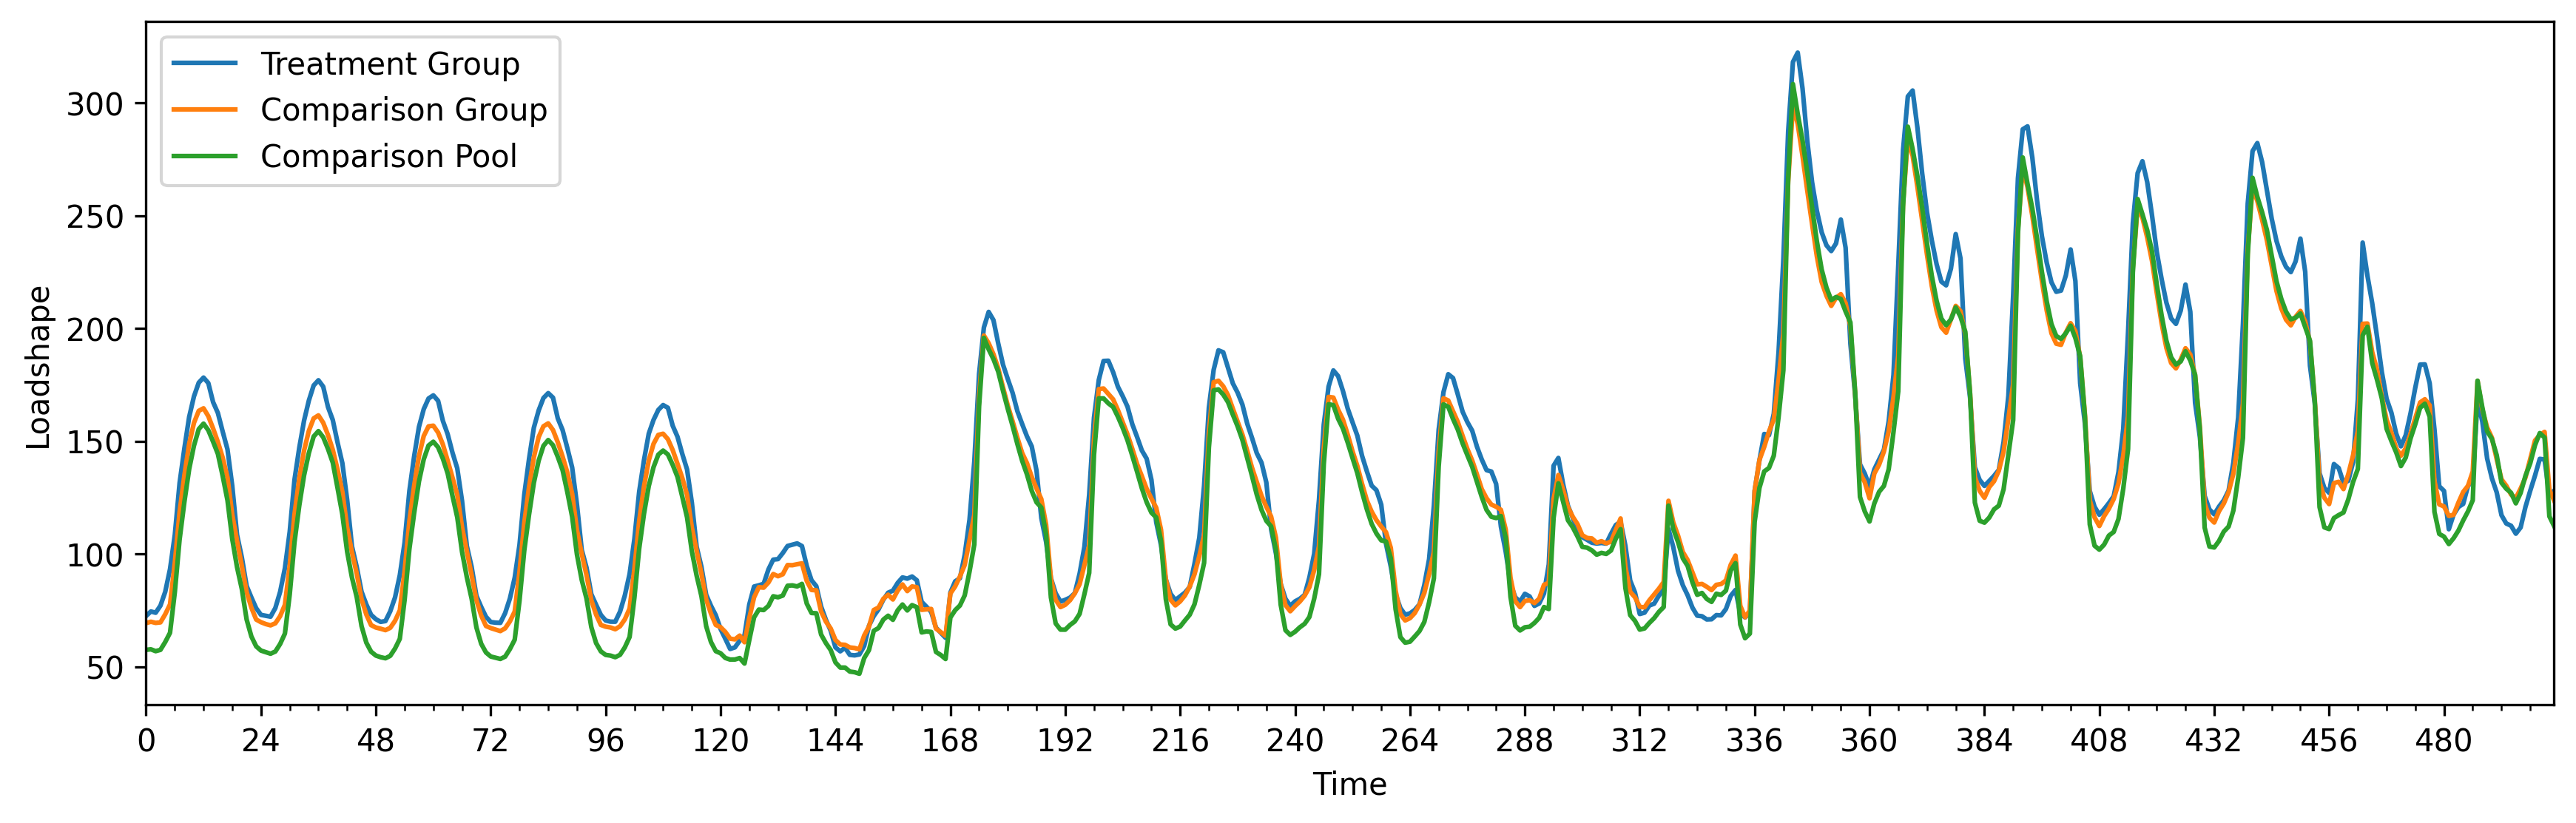

In [9]:
imm.plot_loadshapes()

# Clustering

Clustering was developed to be used with model error, but in this example we'll be using observed loadshapes purely to demonstrate the process

In [10]:
clustering_settings = gm.Clustering_Settings(USE_MULTIPROCESSING=True)
clustering = gm.Clustering(clustering_settings)
df_cg, df_t_coeffs = clustering.get_comparison_group(treatment_data, pool_data)

In [11]:
df_cg

,cluster
id,
118482,0
119310,0
114623,0
110858,0
114967,0
...,...
115762,7
113015,7
119512,7


In [12]:
df_t_coeffs

,pct_cluster_0,pct_cluster_1,pct_cluster_2,pct_cluster_3,pct_cluster_4,pct_cluster_5,pct_cluster_6,pct_cluster_7
id,,,,,,,,
109985,0.870586,0.129414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
109227,0.044652,0.221651,0.000000,0.000000,0.449400,0.027434,0.256863,0.000000
119858,0.000000,0.146927,0.402178,0.132650,0.000000,0.000000,0.000000,0.318244
112900,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
119214,0.253871,0.055837,0.310467,0.000000,0.000000,0.000000,0.000000,0.379825
...,...,...,...,...,...,...,...,...
109164,0.000000,0.000000,0.000023,0.688825,0.000000,0.311153,0.000000,0.000000
113632,0.288282,0.261299,0.000000,0.000000,0.450419,0.000000,0.000000,0.000000
115995,0.821388,0.000000,0.000000,0.084148,0.000000,0.000000,0.094463,0.000000


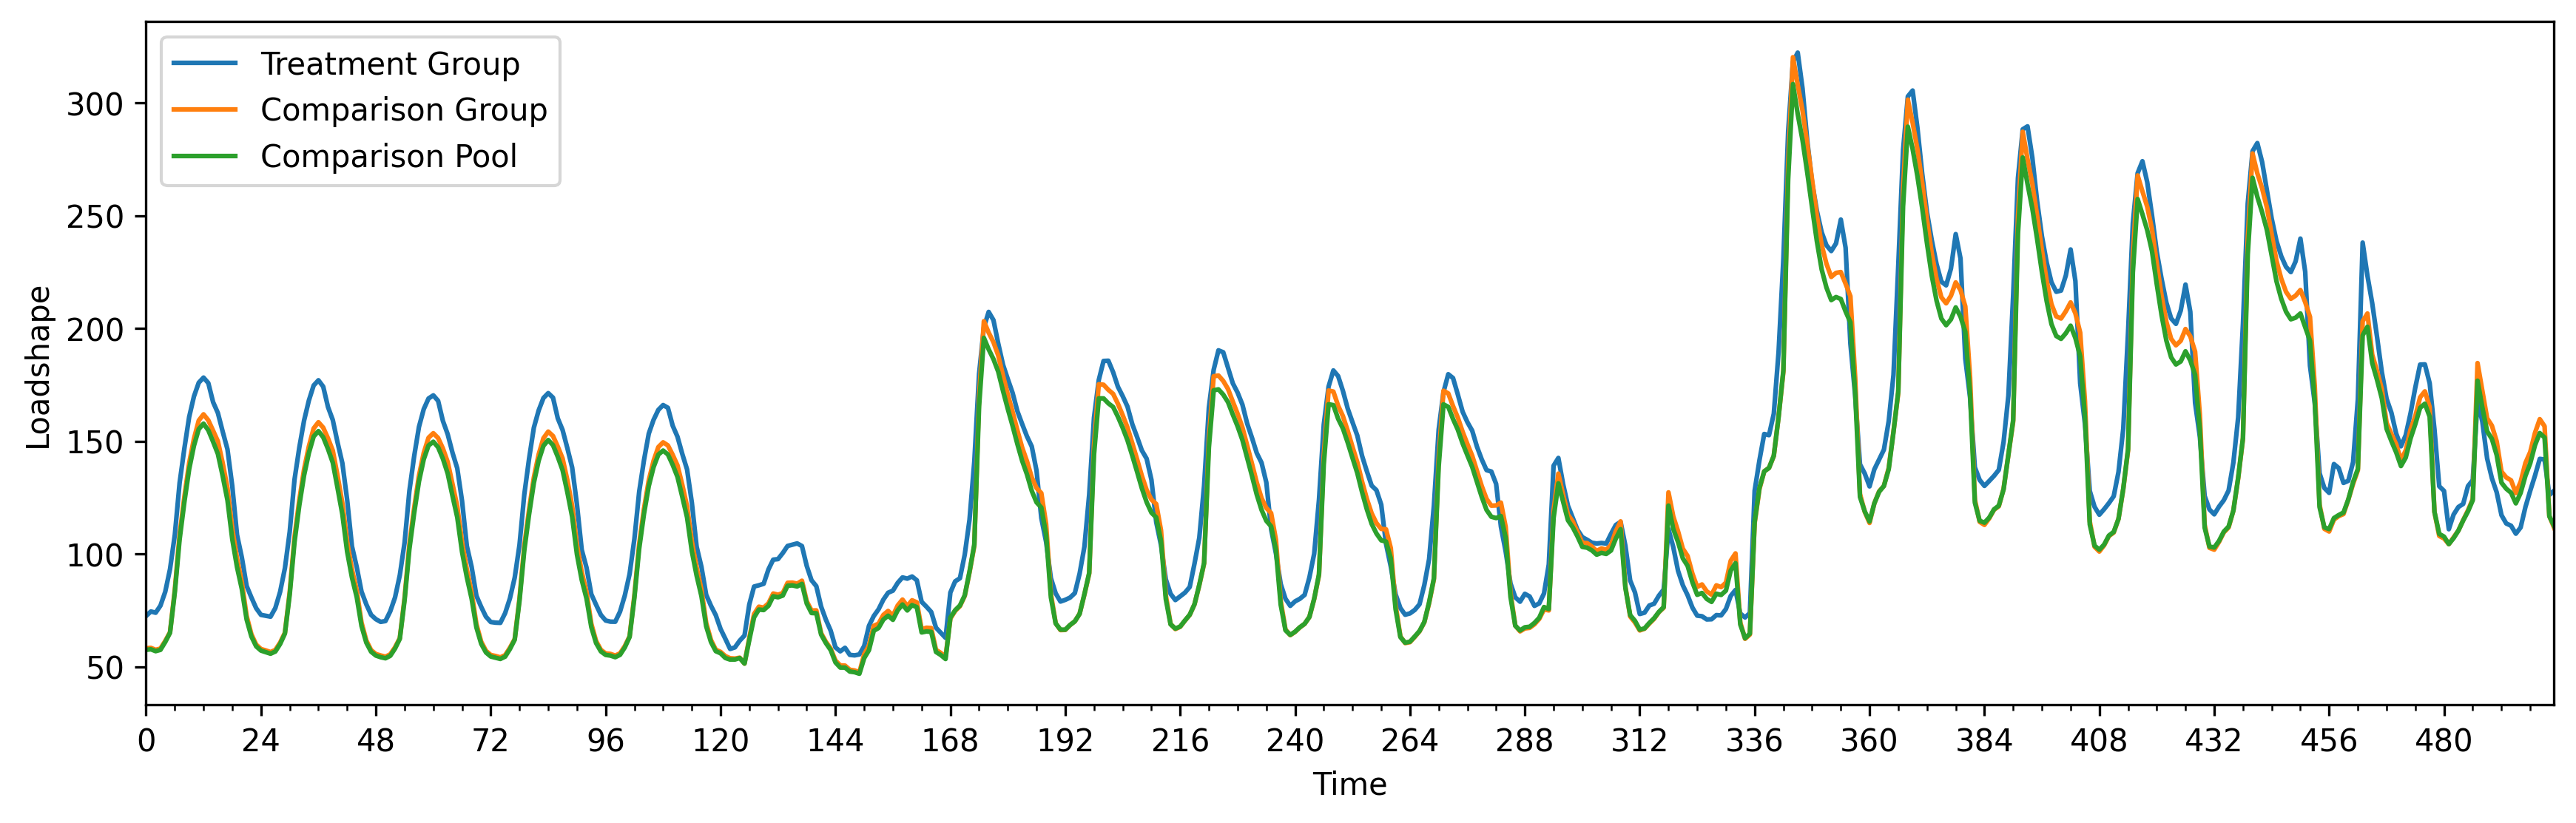

In [13]:
clustering.plot_loadshapes()